# Lab 1 - Mateusz Markiewicz (298653)

## Ex 1

Generate the design matrix $X_{1000×950}$ such that its elements are iid random variables from $N(0, \sigma = \sqrt\frac{1}{1000})$. Then generate the vector of the response variable according to the model

$$Y = X \beta + \epsilon$$
where $\beta = (3, 3, 3, 3, 3, 0, ..., 0)^T$ and $\epsilon ∼ N(0, I)$.

Perform the following analyses using the model with 5,10,20,100,500,950 first variables.

In [1]:
n<-1000;
p<-950;
k<-5;
X<-rnorm(n*p,0,1/sqrt(n));
X<-matrix(X,nrow=n);
beta<-rep(0,p);
beta[1:k]<-3;
p1<-c(5,10,20,100,500,950);
l1<-length(p1);
Y=X%*%beta+rnorm(n);

### PE

For each of the considered models:

a) Estimate β with the Least Squares method and calculate residual sum of squares and the true expected value of the prediction error $PE = E||X(\beta − \hat{\beta}) + \epsilon^*||^2$, where $\epsilon^* ∼ N(0, I)$ is a new noise vector, independent on the training sample.

b) Use the residual sum of squares to estimate PE assuming that $\sigma$ is known and replacing $\sigma$ with its regular unbiased estimator.

c) Estimate PE using leave-one-out crossvalidation (do not perform analysis 1000 times but apply the formula for leave-one-out cross-validation error provided in class).

In [2]:
rss<-rep(0,l1);
true_pe<-rep(0,l1);
unknown_sigma_pe<-rep(0,l1);
known_sigma_pe<-rep(0,l1);
unknown_sigma_aic<-rep(0,l1);
CV_pe<-rep(0,l1);

In [3]:
for (j in 1:l1)
{   
  Xtemp<-X[,1:p1[j]];
  
  H<-Xtemp%*%solve(t(Xtemp)%*%Xtemp)%*%t(Xtemp);
  dH<-diag(H);
  
  obj1<-lm(Y~X[,1:p1[j]]-1);
  betahat1<-coef(obj1);
  
  true_pe[j] <- sum((Xtemp %*% (beta[1:p1[j]]-betahat1))^2) + n;
  
  rss[j] <- sum(obj1$residuals^2);
  known_sigma_pe[j] <- rss[j] + 2*p1[j];
  
  sigma_est = rss[j]/(n-p1[j]);
  unknown_sigma_pe[j] <- rss[j] + 2*p1[j]*sigma_est;

  unknown_sigma_aic[j] <- n * log(rss[j]) + 2*p1[j];
  
  CV_pe[j] <- sum((obj1$residuals/(1-dH))^2);
}

As expected, RSS decreases while adding new variables to the model, despite that those variables are not important. Therefore, we shouldn't use it during the model selection.

The PE is equal to $PE = E||X(\beta − \hat{\beta}) + \epsilon^*||^2$ which is equal to $PE = X(\beta − \hat{\beta}) + E||\epsilon^*||^2 =  X(\beta − \hat{\beta}) + n*\sigma^2$ which in our case is equl to $PE  =  X(\beta − \hat{\beta}) + n$.

If we know our $\sigma$ (of the $\epsilon^*$), we can use PE estimator in the following form: $\hat{PE} = RSS + 2*k*\sigma$, where k is the number of variables that our model uses.

Unfortunately, in practice, we often don't know about $\epsilon^*$ distribution. We can use its regular unbiased estimator $\hat{\sigma} = \frac{RSS}{n-k}$.

The last option is to use the leave-one-out cross-validation technique, which gives us the following PE estimator: $\hat{PE} = \sum_{i=1}^{n}(\frac{Y_i - \hat{Y_i}}{1 - H_{ii}})^2$.

PE with know $\sigma$ works the best, the version with unbiased $\sigma$ estimator works also quite good, but LOOCV gives misleading results for $p > 500 = n/2$.

Plots:

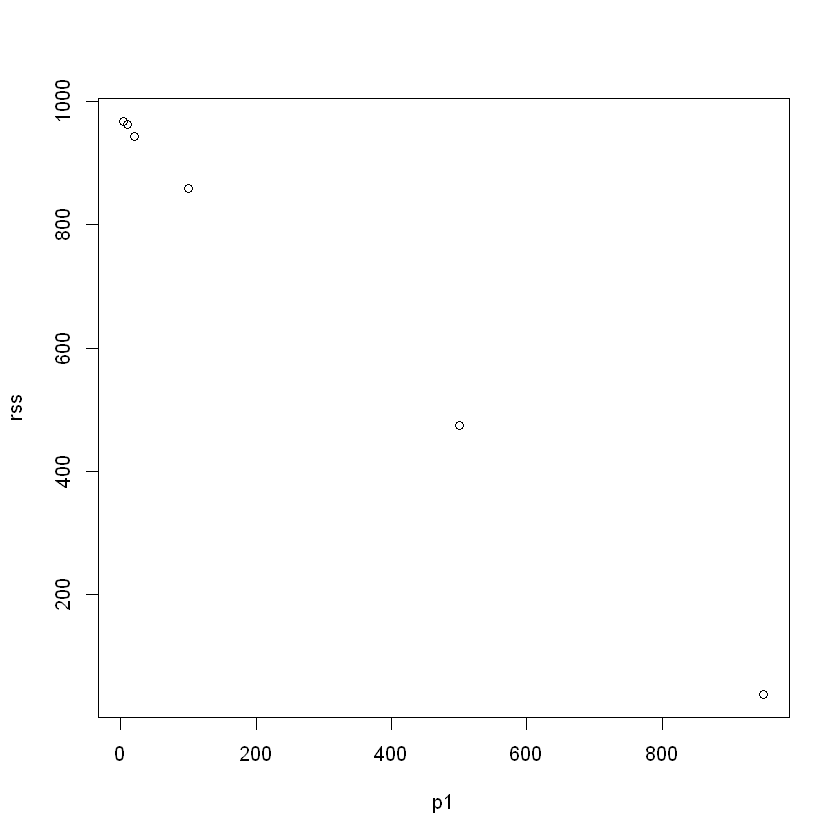

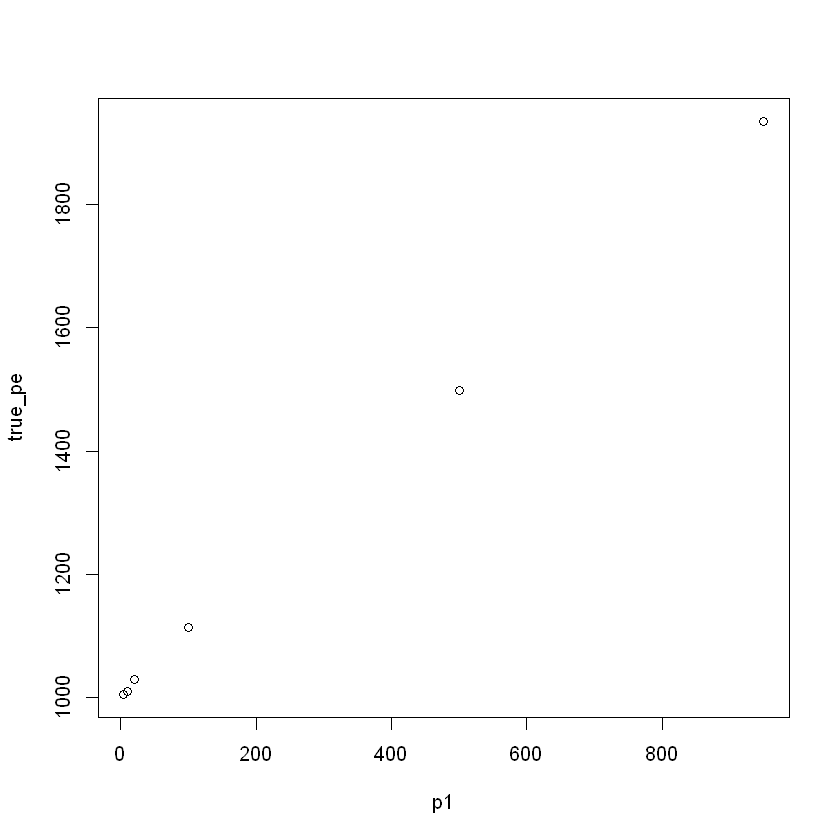

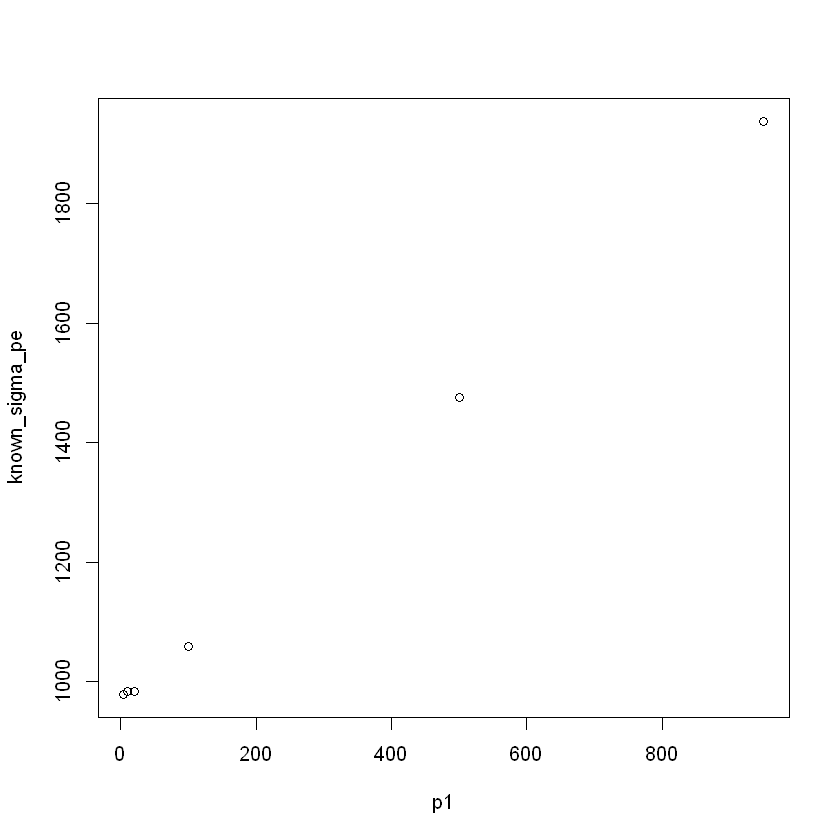

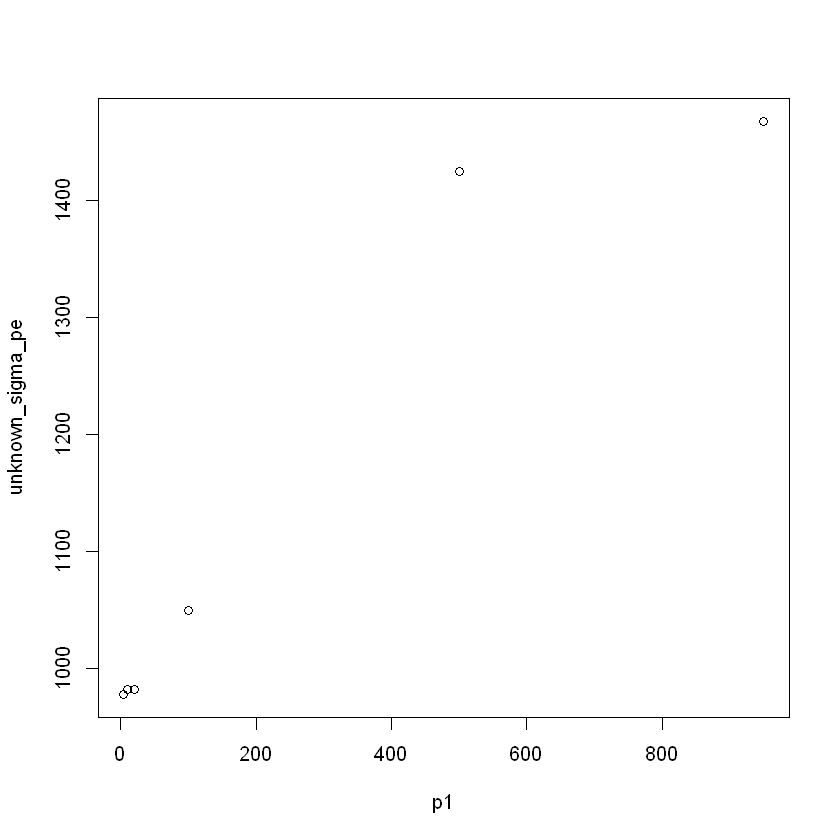

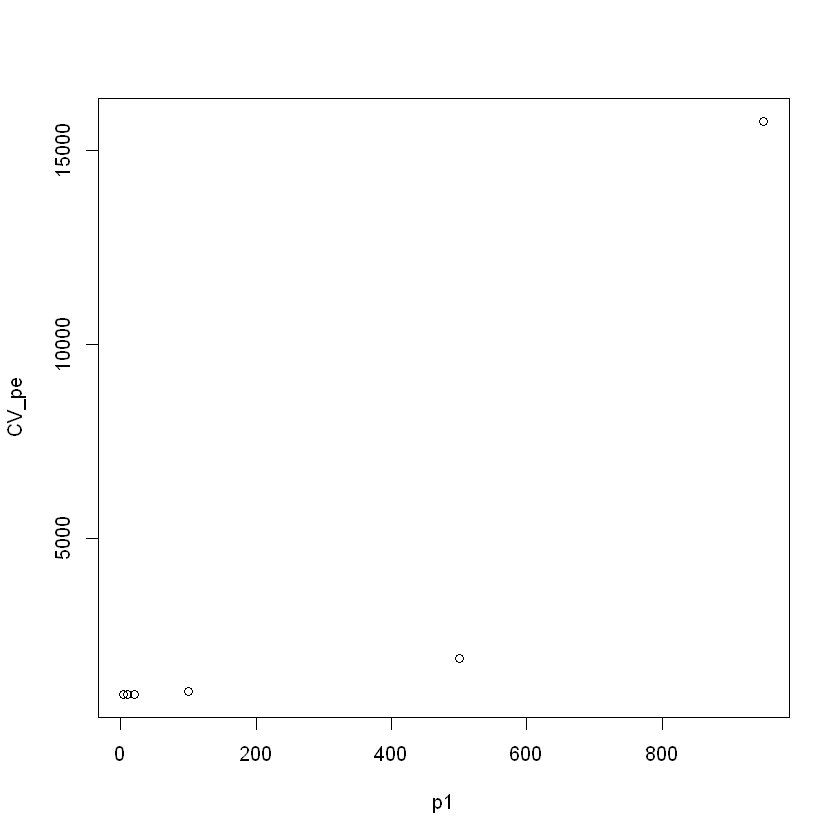

In [4]:
plot(p1, rss);
plot(p1, true_pe);
plot(p1, known_sigma_pe);
plot(p1, unknown_sigma_pe);
plot(p1, CV_pe);

### AIC

Select the optimal model using two versions of AIC: for known and unknown $\sigma$.

In [5]:
print('Number of parameters of the best model with known sigma: ');
print(p1[which.min(known_sigma_pe)]);

print('Number of parameters of the best model with unknown sigma: ');
print(p1[which.min(unknown_sigma_aic)]);

print('Number of parameters of the best model with unknown sigma (using unbiased sigma estimator): ');
print(p1[which.min(unknown_sigma_pe)]);

[1] "Number of parameters of the best model with known sigma: "
[1] 5
[1] "Number of parameters of the best model with unknown sigma: "
[1] 950
[1] "Number of parameters of the best model with unknown sigma (using unbiased sigma estimator): "
[1] 5


There are 3 versions of the AIC formula. The first one, with known $\sigma$, is the same as the PE estimator with known $\sigma$. For unknown $\sigma$ we have two options. We can use an unbiased $\sigma$ estimator which gives the PE formula for unknown sigma or we can use other $\sigma$ estimator $\hat{\sigma}=\frac{RSS}{n}$ which gives us the last AIC formula: $n \log{RSS} + 2k$. Then we have to find a model minimizing those formulas. The first two methods give usually good model selection.

### PE boxplots and AIC accuracy

Repeat the above calculations 100 times and
* for each of the considered models compare the boxplots of $\hat{PE} − PE$ for three estimates of $PE$ , mentioned above.

In [6]:
rep <- 100;

unknown_sigma_pe_err<-rep(0,rep*l1);
unknown_sigma_pe_err<-matrix(unknown_sigma_pe_err,nrow=rep);
known_sigma_pe_err<-rep(0,rep*l1);
known_sigma_pe_err<-matrix(known_sigma_pe_err,nrow=rep);
CV_pr_err<-rep(0,rep*l1);
CV_pr_err<-matrix(CV_pr_err,nrow=rep);

known_sigma_aic<-rep(0,rep*l1);
known_sigma_aic<-matrix(known_sigma_aic,nrow=rep);
unknown_sigma_aic<-rep(0,rep*l1);
unknown_sigma_aic<-matrix(unknown_sigma_aic,nrow=rep);
unknown_sigma_aic_ue<-rep(0,rep*l1);
unknown_sigma_aic_ue<-matrix(unknown_sigma_aic_ue,nrow=rep);

for (i in 1:rep){
  Y=X%*%beta+rnorm(n);
  for (j in 1:l1)
  {   
    Xtemp<-X[,1:p1[j]];
    
    H<-Xtemp%*%solve(t(Xtemp)%*%Xtemp)%*%t(Xtemp);
    dH<-diag(H);
    
    obj1<-lm(Y~X[,1:p1[j]]-1);
    betahat1<-coef(obj1);
    
    true_pe <- sum((Xtemp %*% (beta[1:p1[j]]-betahat1))^2) + n;
    
    rss <- sum(obj1$residuals^2);
    known_sigma_pe_ <- rss + 2*p1[j];
    known_sigma_pe_err[i,j] <- known_sigma_pe_ - true_pe;
    known_sigma_aic[i,j] <- known_sigma_pe_;
    
    sigma_est = rss/(n-p1[j]);
    unknown_sigma_pe_ <- rss + 2*p1[j]*sigma_est;
    unknown_sigma_pe_err[i,j] <- unknown_sigma_pe_ - true_pe;
    unknown_sigma_aic_ue[i,j] <- unknown_sigma_pe_;
    
    unknown_sigma_aic_ <- n * log(rss) + 2*p1[j];
    unknown_sigma_aic[i,j] <- unknown_sigma_aic_;
    
    CV_pr_err[i,j] <- sum((obj1$residuals/(1-dH))^2) - true_pe;
  }
}

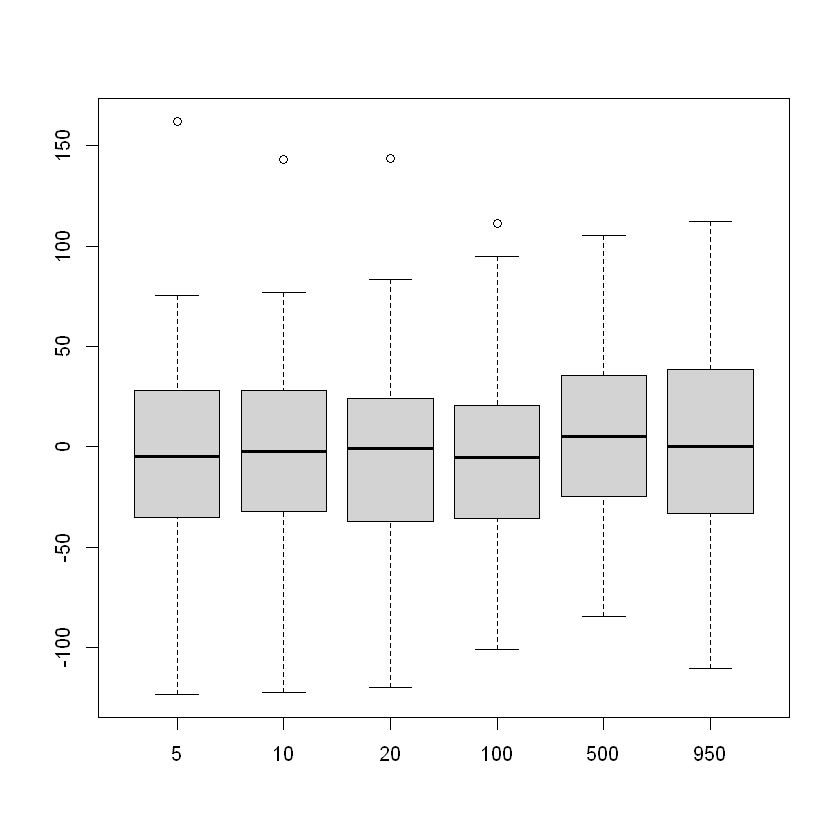

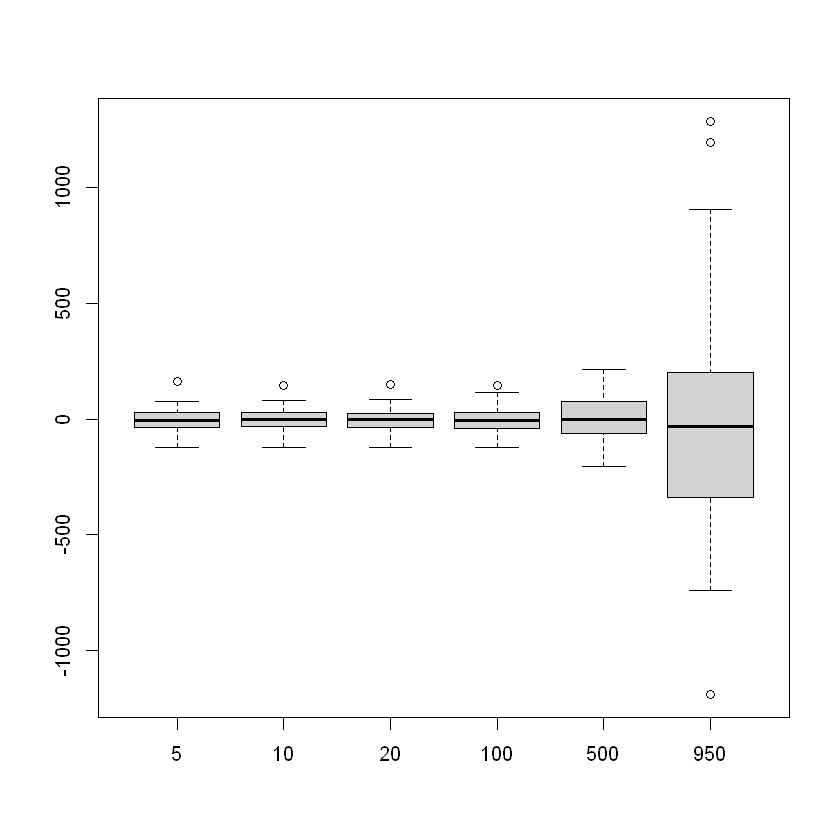

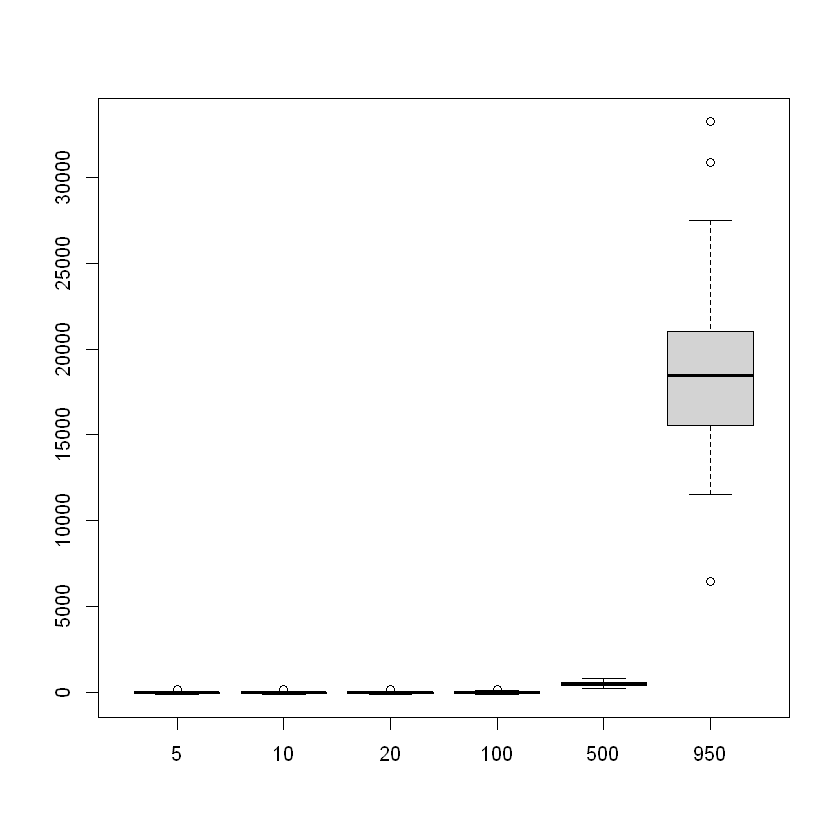

In [7]:
boxplot(known_sigma_pe_err, names=p1);
boxplot(unknown_sigma_pe_err, names=p1);
boxplot(CV_pr_err, names=p1);

The accuracy of different types of AIC calculations:

In [5]:
library(ramify);

In [11]:
print('AIC with known sigma accuracy:');
print(mean(argmin(known_sigma_aic)==1));

print('AIC with unknown sigma accuracy:');
print(mean(argmin(unknown_sigma_aic)==1));

print('AIC with unknown sigma and unbiased sigma estimator accuracy:');
print(mean(argmin(unknown_sigma_aic_ue)==1));

[1] "AIC with known sigma accuracy:"
[1] 0.9
[1] "AIC with unknown sigma accuracy:"
[1] 0
[1] "AIC with unknown sigma and unbiased sigma estimator accuracy:"
[1] 0.9


As we can see both LOOCV as PE estimator and the log version of AIC criterion gives misleading results when $p > n/2$

## Ex 2

Use BIC, AIC, RIC, mBIC i mBIC2 (you can use bigstep library in R) to identify important covariates when the search is performed over the data base date consisting of 20, 50, 100, 500 and 950 first variables.

a) Report the number of false and true discoveries and the square error of the estimation of
the vector of expected values of $Y : ||X\beta − \hat{Y}||^2$

b) Repeat point a) 100 times and report the estimated power, FDR and mean squared error of the estimation of expected values of Y for all criteria considered above. Critically summarize the results.


### Single experiment

In [3]:
library('bigstep');

In [12]:
n<-1000;
p<-950;
k<-5;
X<-rnorm(n*p,0,1/sqrt(n));
X<-matrix(X,nrow=n);
beta<-rep(0,p);
beta[1:k]<-3;
p1<-c(20, 50, 100, 500, 950);
l1<-length(p1);
Y=X%*%beta+rnorm(n);

In [13]:
ric <- function(loglik, k, p) {
  stopifnot(k >= 0, p > 0, p/k >= 1)
  ric_v <- -2*loglik + 2*k*log(p)
  return(ric_v)
}

In [14]:
crits <- c("aic", "bic", "ric", "mbic", "mbic2");
cl <- length(crits);

true_variables<-rep(0,cl*l1);
true_variables<-matrix(true_variables,nrow=cl);
false_variables<-rep(0,cl*l1);
false_variables<-matrix(false_variables,nrow=cl);

errors <- rep(0,cl*l1);
errors<-matrix(errors,nrow=cl);

X_beta <- X %*% beta;

for (i in 1:cl){
  for (j in 1:l1)
    {   
      Xtemp<-X[,1:p1[j]];
      dat<-prepare_data(Y, Xtemp, verbose = FALSE); 
      if (i == 1){
        obj1<-fast_forward(dat, crit=crits[i], maxf=p1[j]);
      } else {
        obj1<-stepwise(dat, crit=crits[i], maxf=p1[j]);
      }
      l<-length(obj1$model);
      if (l==0){
        true_variables[i,j] <- 0;
        false_variables[i, j] <- 0;
        errors[i,j] <- sum((X_beta)^2)
        next;
      }
  
      for (v in as.numeric(obj1$model)){
          if (v < 6){
          true_variables[i,j] <- true_variables[i, j] + 1;
        }
      }
      false_variables[i, j] <- l - true_variables[i, j];
      
      betas_hat <- summary(obj1)$coefficient[1:l+1];
      Xtemp2 <- X[,as.numeric(obj1$model)];
      
      if (l > 1){
        Y_hat = Xtemp2 %*% betas_hat;
      } else{
        Y_hat = Xtemp2 * betas_hat;
      }
      
      errors[i,j] <- sum((X_beta - Y_hat)^2)
  }
}

In [17]:
print('True discoveries')
df <- data.frame(true_variables);
rownames(df) <- crits;
colnames(df) <- p1;
print(df)

[1] "True discoveries"
      20 50 100 500 950
aic    4  4   4   4   4
bic    4  4   3   3   2
ric    4  2   0   0   0
mbic   0  0   0   0   0
mbic2  0  0   0   0   0


In [18]:
print('False discoveries')
df <- data.frame(false_variables);
rownames(df) <- crits;
colnames(df) <- p1;
print(df)

[1] "False discoveries"
      20 50 100 500 950
aic    4  7  20  79 164
bic    0  0   2   4  20
ric    0  0   0   0   0
mbic   0  0   0   0   0
mbic2  0  0   0   0   0


In [19]:
print('errors')
df <- data.frame(errors);
rownames(df) <- crits;
colnames(df) <- p1;
print(df)

[1] "errors"
             20        50      100       500       950
aic   18.676022 26.227872 72.34679 241.57299 464.06841
bic    8.940136  8.940136 31.14088  48.23350 171.22372
ric    8.940136 26.077724 43.28851  43.28851  43.28851
mbic  43.288508 43.288508 43.28851  43.28851  43.28851
mbic2 43.288508 43.288508 43.28851  43.28851  43.28851


### 100 iterations

In [20]:
rep <- 100;

FPR <- rep(0,rep*cl*l1);
FPR <- array(FPR, c(rep,cl,l1));

TD <- rep(0,rep*cl*l1);
TD <- array(TD, c(rep,cl,l1));

mean_errors <- rep(0,rep*cl*l1);
mean_errors <- array(mean_errors, c(rep,cl,l1));

X_beta <- X %*% beta;
X_beta_SS <- sum((X_beta)^2);

for (k in 1:rep){
  Y=X%*%beta+rnorm(n);
  for (i in 1:cl){
    for (j in 1:l1)
      {   
        true_variables_ <- 0;
        Xtemp<-X[,1:p1[j]];
        dat<-prepare_data(Y, Xtemp, verbose = FALSE); 
        if (i == 1){
          obj1<-fast_forward(dat, crit=crits[i], maxf=p1[j]);
        } else {
          obj1<-stepwise(dat, crit=crits[i], maxf=p1[j]);
        }
        l<-length(obj1$model);
        
        if (l==0){
          FPR[k, i, j] <- 0;
          TD[k, i, j] <- 0;
          mean_errors[k,i,j] <- X_beta_SS;
          next;
        }
    
        for (v in as.numeric(obj1$model)){
          if (v < 6){
            true_variables_ <- true_variables_ + 1;
          }
        }
        FPR[k, i, j] <- 1 - true_variables_/l;
        TD[k, i, j] <- true_variables_;
        
        betas_hat <- summary(obj1)$coefficient[1:l+1];
        Xtemp2 <- X[,as.numeric(obj1$model)];

        if (l > 1){
          Y_hat = Xtemp2 %*% betas_hat;
        } else{
          Y_hat = Xtemp2 * betas_hat;
        }
        mean_errors[k,i,j] <- sum((X_beta - Y_hat)^2)
    }
  }
}


In [21]:
print('FDR with respect to k and criterion')
a <-apply(FPR, c(2,3), mean);
df <- data.frame(a);
rownames(df) <- crits;
colnames(df) <- p1;
print(df)

[1] "FDR with respect to k and criterion"
              20         50        100        500       950
aic   0.29656962 0.57511144 0.74811441 0.94562541 0.9726999
bic   0.04766667 0.10452381 0.18398810 0.56692664 0.7499594
ric   0.05283333 0.07600000 0.05266667 0.08450000 0.1200000
mbic  0.01333333 0.01333333 0.02000000 0.01000000 0.0200000
mbic2 0.02916667 0.02800000 0.02700000 0.01333333 0.0200000


In [22]:
print('Power with respect to k and criterion')
a <-apply(TD, c(2,3), mean)/5;
df <- data.frame(a);
rownames(df) <- crits;
colnames(df) <- p1;
print(df)

[1] "Power with respect to k and criterion"
         20    50   100   500   950
aic   0.926 0.926 0.926 0.926 0.926
bic   0.636 0.634 0.636 0.628 0.614
ric   0.702 0.574 0.466 0.244 0.190
mbic  0.412 0.276 0.208 0.092 0.052
mbic2 0.576 0.386 0.270 0.106 0.056


In [23]:
print('Error with respect to k and criterion')
a <-apply(mean_errors, c(2,3), mean);
df <- data.frame(a);
rownames(df) <- crits;
colnames(df) <- p1;
print(df)

[1] "Error with respect to k and criterion"
            20       50      100       500       950
aic   14.40262 30.42139 57.25293 265.72532 472.95103
bic   19.33325 21.73663 25.26969  57.63486 100.35714
ric   16.95828 23.50139 27.47833  36.84498  39.76459
mbic  28.34000 34.06744 36.72777  40.77697  42.26533
mbic2 21.73617 30.12649 34.62745  40.40093  42.13911


False Discoveries rate:
* FDR is the highest (as expected) for the AIC, this is because the penalty term doesn't depend on the number of samples and there is no multiple testing correction. 
* BIC got better results, because of different penalty term, but there is still no multiple testing correction, so for bigger $p$ values, FDR is still very high.
* RIC include multiple testing correction, therefore FDR is significantly lower than before.
* mBIC and mBIC2 improve the FDR rate ever further.

Power
* Power of AIC and BIC is stable with respect to $k$, and is highest for AIC because AIC has a smaller penalty in this case.
* Power of the RIC for $p=20$ is higher than the power of BIC but decreases with respect to $k$.
* mBIC and mBIC2 gots a bit worse results than RIC (because of weak signal), and as expected, their power also decreases with respect to $k$. In terms of power, mBIC2 is better than mBIC

Error
* when $p=20$ AIC gives a smaller error because it can discover all (or most of) true variables and p is small enough to prevent from adding false discoveries.
* when $p=50$ or $p=100$ BIC gives a smaller error because it has a smaller FDR than AIC and higher TDR than the rest of the criteria.
* when $p > 100$ RIC, mBIC and mBIC2 give significantly better results, and they are comparable (but RIC is usually on top).

## Ex 3

Compare RIC, mBIC and mBIC2 using last example of Problem 2 when the vector of true regression coefficients contains 50 nonzero entries, i.e. $\beta_i = 3$ for $i = 1, . . . , 50$ and $\beta_i = 0$ for $i = 51, . . . , 950$.

In [24]:
n<-1000;
p<-950;
k<-50;
X<-rnorm(n*p,0,1/sqrt(n));
X<-matrix(X,nrow=n);
beta<-rep(0,p);
beta[1:k]<-3;
Y=X%*%beta+rnorm(n);

In [25]:
rep <- 200;

crits <- c("ric", "mbic", "mbic2");
cl <- length(crits);

FPR <- rep(0,rep*cl);
FPR <- array(FPR, c(rep,cl));

TD <- rep(0,rep*cl);
TD <- array(TD, c(rep,cl));

mean_errors <- rep(0,rep*cl);
mean_errors <- array(mean_errors, c(rep,cl));

X_beta <- X %*% beta;
X_beta_SS <- sum((X_beta)^2);

for (k in 1:rep){
  Y=X%*%beta+rnorm(n);
  for (i in 1:cl){
      true_variables_ <- 0;
      dat<-prepare_data(Y, X, verbose = FALSE); 
      obj1<-stepwise(dat, crit=crits[i], maxf=950);
      l<-length(obj1$model);
      if (l==0){
        FPR[k, i] <- 0;
        TD[k, i] <- 0;
        mean_errors[k,i] <- X_beta_SS;
        next;
      }
  
      for (v in as.numeric(obj1$model)){
        if (v < 6){
          true_variables_ <- true_variables_ + 1;
        }
      }
      FPR[k, i] <- 1 - true_variables_/l;
      TD[k, i] <- true_variables_;
      
      betas_hat <- summary(obj1)$coefficient[1:l+1];
      Xtemp2 <- X[,as.numeric(obj1$model)];

      if (l > 1){
        Y_hat = Xtemp2 %*% betas_hat;
      } else{
        Y_hat = Xtemp2 * betas_hat;
      }
      mean_errors[k,i] <- sum((X_beta - Y_hat)^2)
  }
}

In [26]:
a <- apply(FPR, c(2), mean);
b <- apply(TD, c(2), mean)/5;
c <- apply(mean_errors, c(2), mean);
df <- data.frame("FPR"=a, "Power"=b, "MSE"=c);
rownames(df) <- crits;
print(df)

            FPR Power      MSE
ric   0.8572106 0.136 388.3754
mbic  0.7013333 0.056 417.1311
mbic2 0.7109041 0.100 401.1793


In this example, we can see that mBIC2 has much better power than mBIC, while having the same FDR, what leads to smaller error.
Despite the fact that RIC has a higher FDR than mBIC2 it has higher power (because of weak signal) therefore it gives a smaller error.

## Ex 4

Generate the vector of the response variable according to the model $$Y = X\beta + \epsilon$$ where $\beta_1 = . . . = \beta_30 = 10$, $\beta_31 = . . . = \beta_950 = 0$ and $\epsilon_1, . . . , \epsilon_n$ are iid from a
* shifted exponential distribution with $\lambda = 1$
* Cauchy distribution

i) Use mBIC, mBIC2, rBIC and rBIC2 to identify important covariates. Report the number of true and false discoveries.

ii) Use variables selected by rBIC2 and estimate the corresponding regression coefficients using least squares as well as the robust regression based on the Huber and Bi-square objective functions. Report the mean square error of estimation of regression coefficients.

iii) Repeat this experiment 100 times and report estimated FDR and Power. For this part you do not need to estimate regression coefficients (i.e. you do not need to perform step ii).

### Single experiment

In [27]:
n<-1000;
p<-950;
k<-30;

X<-rnorm(n*p,0,1/sqrt(n));
X<-matrix(X,nrow=n);
beta<-rep(0,p);
beta[1:k]<-10;

XB <- X%*%beta;

In [34]:
crits <- c("mbic", "mbic2", "mbic", "mbic2");
cl <- length(crits);

FD <- rep(0,2*cl);
FD <- array(FD, c(2,cl));
TD <- rep(0,2*cl);
TD <- array(TD, c(2,cl));

for (i in 1:2){
  
  if (i==1){
    Y = XB + rexp(n) -1;
    Y_ <- Y;
  } else {
    Y = XB + rcauchy(n);
  }
  
  for (j in 1:cl){
    if (j < 3){
      dat<-prepare_data(Y, X, verbose = FALSE);
    } else{
      rY = rank(Y);
      dat<-prepare_data(rY, X, verbose = FALSE); 
    }
    
    obj1<-stepwise(dat, crit=crits[j], maxf=p);
    
    selected <- as.numeric(obj1$model);
    if (i==1){
      selected_ <- selected;
    }
    l <- length(selected);
    TD[i,j] <- sum(is.element(1:k, selected));
    FD[i,j] <- l - TD[i,j];
  }
}

In [35]:
df = data.frame(FD_exp=FD[1,],TD_exp=TD[1,], FD_cauchy=FD[2,], TD_cauchy=TD[2,])
rownames(df) <- c('mBIC', 'mBIC2', 'rBIC', 'rBIC2')
print(df)

      FD_exp TD_exp FD_cauchy TD_cauchy
mBIC       0     30         0         0
mBIC2      2     30         0         0
rBIC       0     30         0        11
rBIC2      0     30         1        19


In [45]:
library(MASS)
betas_MSE <- rep(0,6);
betas_MSE <- array(betas_MSE, c(2,3));

X_temp = X[,selected_];

model<-lm(Y_~X_temp-1)
betas_est <- (summary(model))$coefficients[,1];
betas_hat <- rep(0,950);
betas_hat[selected_] <- betas_est;
betas_MSE[1,1] <- sum((beta - betas_hat)^2)

model<-rlm(X_temp,Y_,psi=psi.huber)
betas_est <- (summary(model))$coefficients[,1];
betas_hat <- rep(0,950);
betas_hat[selected_] <- betas_est;
betas_MSE[1,2] <- sum((beta - betas_hat)^2)

model<-rlm(X_temp,Y_,psi=psi.bisquare)
betas_est <- (summary(model))$coefficients[,1];
betas_hat <- rep(0,950);
betas_hat[selected_] <- betas_est;
betas_MSE[1,3] <- sum((beta - betas_hat)^2)

X_temp = X[,selected];

model<-lm(Y~X_temp-1)
betas_est <- (summary(model))$coefficients[,1];
betas_hat <- rep(0,950);
betas_hat[selected] <- betas_est;
betas_MSE[2,1] <- sum((beta - betas_hat)^2)

model<-rlm(X_temp,Y,psi=psi.huber)
betas_est <- (summary(model))$coefficients[,1];
betas_hat <- rep(0,950);
betas_hat[selected] <- betas_est;
betas_MSE[2,2] <- sum((beta - betas_hat)^2)

model<-rlm(X_temp,Y,psi=psi.bisquare)
betas_est <- (summary(model))$coefficients[,1];
betas_hat <- rep(0,950);
betas_hat[selected] <- betas_est;
betas_MSE[2,3] <- sum((beta - betas_hat)^2)

df <- data.frame(betas_MSE);
colnames(df) <- c('Least squares', 'Huber', 'Bi-square');
rownames(df) <- c('Exponential distribution', 'Cauchy distribution')
print(df);

                         Least squares      Huber Bi-square
Exponential distribution      32.02563   18.21123   18.0852
Cauchy distribution        17005.65808 1278.21878 1221.1751


### 100 iterations

In [46]:
reps <- 100;

FD <- rep(0,reps*2*cl);
FD <- array(FD, c(reps,2,cl));
TD <- rep(0,reps*2*cl);
TD <- array(TD, c(reps,2,cl));

crits <- c("mbic", "mbic2", "mbic", "mbic2");
cl <- length(crits);

for (z in 1:reps){
  for (i in 1:2){
    
    if (i==1){
      Y = XB + rexp(n) -1;
    } else {
      Y = XB + rcauchy(n);
    }
    
    for (j in 1:cl){
      if (j < 3){
        dat<-prepare_data(Y, X, verbose = FALSE);
      } else{
        rY = rank(Y);
        dat<-prepare_data(rY, X, verbose = FALSE); 
      }
      
      obj1<-stepwise(dat, crit=crits[j], maxf=p);
      
      selected <- as.numeric(obj1$model);

      l <- length(selected);
      if (l==0){
        next;
      }
      TD[z,i,j] <- sum(is.element(1:k, selected));
      FD[z,i,j] <- (l - TD[z,i,j])/l;
    }
  }
}

In [47]:
a <- apply(FD, c(2,3), mean);
b <- apply(TD, c(2,3), mean)/k;

df = data.frame(FDR_exp=a[1,],Power_exp=b[1,], FDR_cauchy=a[2,], Power_cauchy=b[2,])
rownames(df) <- c('mBIC', 'mBIC2', 'rBIC', 'rBIC2')
print(df)

           FDR_exp Power_exp  FDR_cauchy Power_cauchy
mBIC  0.0009677419         1 0.020000000    0.0000000
mBIC2 0.0270384774         1 0.020000000    0.0000000
rBIC  0.0009677419         1 0.001666667    0.2470000
rBIC2 0.0342568354         1 0.029745629    0.5723333


When error terms were generated from shifted exponential distribution all of the methods were able to select all true variables. The rBIC2 criterion gives some false discoveries, but FDR is still small.  The mean square error of estimation of regression coefficients is small for all the regression types, but LS-regression gives worse results than the rest.

When error terms were generated from Cauchy distribution mBIC and mBIC2 is selecting 0 variables. It's heavy tail distribution and there are a lot of outliers in the data, therefore the standard approach fails. Ranking the Y vector helps us dealing with outliers and thanks to that rBIC and rBIC2 are able to detect at least par of the true variables. mBIC2 has larger power, but it's generating some false discoveries. In LS-regression outliers significantly affect the results, therefore the MSE of the betas estimation is very large. Using the robust regression based on the Huber and Bi-square objective functions gives better results.

## Ex 5

Use our design matrix and generate the binary response variable according to the logistic regression model: $$p_i = P(Y_i) = 1 - P(Y_i = 0)$$
$$log(\frac{p_i}{1-p_i}) = X_i \beta$$ where $\beta_1 = . . . = \beta_30 = 10$, $\beta_31 = . . . = \beta_950 = 0$.

i) Use AIC, BIC, mBIC and mBIC2 to identify important covariates. Report the number of true and false discoveries.

ii) Use variables selected by these criteria and estimate the corresponding regression coefficients using logistic regression in a reduced model. Report the squared error of estimation of regression coefficients.

iii) Repeat this experiment 100 times and report estimated FDR, Power and MSE.

### Single experiment

In [1]:
n <- 1000;
p <- 950;
k <- 30;
X<-rnorm(n*p,0,1/sqrt(n));
X<-matrix(X,nrow=n);
beta<-rep(0,p)
beta[1:k]<-10;
logit<-X%*%beta;
pr=exp(logit)/(1+exp(logit));
Y<-rbinom(n,1,pr);

In [6]:
crits <- c("aic", "bic", "mbic", "mbic2");
cl <- length(crits);

TD <- rep(0, cl);
FD <- rep(0, cl);
betas_MSE <- rep(0, cl);

for (i in 1:cl){
  d<-prepare_data(Y, X, type='logistic', verbose = FALSE);
  
  if (i<3){
    obj1<-fast_forward(d,crit=crits[i]);
  } else {
    obj1<-stepwise(d,crit=crits[i]);
  }
  
  selected <- as.numeric(obj1$model);
  l <- length(selected);
  if (l==0){
    next;
  }
  TD[i] <- sum(is.element(1:k, selected));
  FD[i] <- l - TD[i];
  
  X_temp = X[,selected];

  
  obj2<-glm(Y~X_temp, family='binomial');
  betas_est <- obj2$coefficients[1:l+1];
  betas_hat <- rep(0,950);
  betas_hat[selected] <- betas_est;
  betas_MSE[i] <- sum((beta - betas_hat)^2);
}

In [7]:
df <- data.frame(TD = TD, FD = FD, Bethas_MSE = betas_MSE);
rownames(df) <- crits;
print(df)

      TD FD Bethas_MSE
aic   30 40   2003.103
bic   23 12   1654.636
mbic   6  0   2405.623
mbic2 20  1   1166.415


### 100 iterations

In [8]:
reps <- 100;

TD <- rep(0, reps*cl);
TD <- array(TD, c(reps,cl));
FD <- rep(0, reps*cl);
FD <- array(FD, c(reps,cl));
betas_MSE <- rep(0, reps*cl);
betas_MSE <- array(betas_MSE, c(reps,cl));

for (j in 1:reps){
  for (i in 1:cl){
    d<-prepare_data(Y, X, type='logistic', verbose = FALSE);
    
    if (i<3){
      obj1<-fast_forward(d,crit=crits[i]);
    } else {
      obj1<-stepwise(d,crit=crits[i]);
    }
    
    selected <- as.numeric(obj1$model);
    l <- length(selected);
    if (l==0){
      next;
    }
    TD[j,i] <- sum(is.element(1:k, selected));
    FD[j,i] <- (l - TD[j,i])/l;
    
    X_temp = X[,selected];
  
    
    obj2<-glm(Y~X_temp, family='binomial');
    betas_est <- obj2$coefficients[1:l+1];
    betas_hat <- rep(0,950);
    betas_hat[selected] <- betas_est;
    betas_MSE[j,i] <- sum((beta - betas_hat)^2);
    
  }
}

In [9]:
a <- apply(FD, c(2), mean);
b <- apply(TD, c(2), mean)/k;
c <- apply(betas_MSE, c(2), mean);

df <- data.frame(FDR = a, Power = b, Bethas_MSE = c);
rownames(df) <- crits;
print(df)

             FDR     Power Bethas_MSE
aic   0.57142857 1.0000000   2003.103
bic   0.34285714 0.7666667   1654.636
mbic  0.00000000 0.2000000   2405.623
mbic2 0.04761905 0.6666667   1166.415


In this assignment, we can see that discussed criteria are able to detect important variables also when using logistic regression. As in assignment 2, AIC has the best power, but the worst FDR (because of lack of multiple testing correction). BIC improves the results of the AIC, but still generates false discoveries. mBIC and mBIC2 significantly reduce FDR and the mBIC2 has better power than mBIC. Those results affect the MSE of betas estimation - mBIC2 gives the smallest beta's MSE because it discovers most of the true variables without adding additional ones. mBIC gives the worst MSE because of weak power, and AIC also has high MSE because of high FDR.